# Transformer를 이용한 한국어 챗봇 모델 생성 예제

<br><br>

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; Transformer 한국어 챗봇 모델을 생성하고 BLEU를 이용하여 모델을 평가하였다. 송영숙(2018)이 제시한 『Chatbot data for Korean v1』을 학습 데이터셋으로 사용 하였다. 데이터 분석 결과 총 레코드 수는 11,823개이며, 결측치 0개, 중복 데이터 73개가 존재하였다. 따라서, '중복 데이터 제거' ,'정규식을 이용한 문장 전처리', '형태소 기준 문장 분할'을 수행하여 총 11,750개의 데이터를 확보하고 테스트 데이터 100개, 학습 데이터 11,650개로 분할 하였다. 문장 길이와 토큰 사용 빈도를 분석하여, 질문 데이터의 경우 토큰이 15개 이하로 사용되고 대답 데이터의 경우에는 토큰이 18개 이하로 사용된 문장만을 추출하였다. 또한 토크나이저의 단어사전 크기는 5,872개로 설정하였다. 이후, 이미 학습된 Word2Vec을 이용하여 데이터 증강을 수행하였으며, 최종 29,951개의 학습 데이터를 확보 하였다. 모델 생성 시, 인코더와 디코더 레이어는 2층을 쌓았으며, 학습 데이터 수가 적기 때문에 벡터 사이즈와 피드포워드 레이어의 유닛 수를 128로 설정 하였다. 학습 옵티마이저는 Adam을 사용하며 배치 사이즈는 64로 설정하고 총 10회 학습 하였다. 「지루하다, 놀러가고 싶어.」, 「오늘 일찍 일어났더니 피곤하다.」 등의 총 4개의 문장을 입력한 결과, 「시간이 필요한가 봐요.」, 「아침 일이 많았나 봅니다.」 등의 문장을 출력하였다. 앞서 분할한 100개의 테스트 데이터에 대한 모델의 BLEU score는 0.419임을 확인하였다. 이는 '이해할 수 있는 양호한 문장'으로 Transformer 한국어 챗봇 모델의 성능은 양호한 수준이라 평가할 수 있다.
</span>

***

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제는 Transformer를 이용하여 한국어 챗봇 모델을 생성하고 평가하는 것을 목표로 합니다. 학습 데이터셋은 송영숙(2018)이 제시한 『Chatbot data for Korean v1』를 이용 하며, 적은 데이터 수를 보완하기 위해, 데이터 증강 기법을 이용하여 데이터 수를 늘릴 것입니다. 나아가, 모델이 출력한 문장을 평가하기 위해 BLEU를 이용 할 것입니다. 다음은 예제의 진행 순서를 제시한 것입니다.
</span><br><br>


> _1. 데이터 분석_
>
> _2. 데이터 전처리_
>
> _3. 데이터 토큰화_
>
> _4. 데이터 증강_
>
> _5. 모델 생성_
>
> _6. 모델 학습_
>
> _7. 모델 평가_


***

#### _예제 진행에 앞서..._
***
+ 예제에서 사용하는 한국어 형태소 분석기 Mecab을 이용하기 위해 미리 설치 하여 줍니다.

> `$ sudo apt-get install g++ openjdk-8-jdk` #jdk 설치
>
> `$ bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)` #curl을 이용한 Mecab 설치
>
> `$ pip install konlpy` #konlpy 설치
***

<br>

## 2. 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 예제에서 사용하는 데이터는 송영숙(2018)이 제시한 『Chatbot data for Korean v1』을 이용합니다. 데이터는 질문과 대답 그리고 질문의 평상, 긍정, 부정에 대한 0에서 2사이의 값으로 이루어져 있습니다. 예제에서는 질문(Question)과 대답(Answer) 데이터만을 이용합니다.  레코드 수는 총 11,823개이며 결측치는 0개, 중복 데이터 73개가 존재 합니다.
</span>

***

#### 필요 라이브러리 호출
***
+ 예제에 필요한 라이브러리를 호출 합니다.
***

In [1]:
import re   #정규식
import random   #데이터 증강용 난수
import numpy as np   #행렬 연산
import pandas as pd   #데이터프레임
import tensorflow as tf   #신경망
import matplotlib.pyplot as plt   #데이터 시각화
from tqdm.notebook import tqdm   #학습 과정 출력


import gensim   #Word2Vec
from konlpy.tag import Mecab   #형태소 분석


from nltk.translate.bleu_score import sentence_bleu   #bleu 연산
from nltk.translate.bleu_score import SmoothingFunction   #bleu 연산

<br>

#### 데이터셋 불러오기
***
+ 질문(Q)과 대답(A) 그리고 일상(0), 부정(1), 긍정(2)의 도메인을 가지는 label로 구성되어 있으며 본 예제에서는 질문(Q)과 대답(A) 데이터만 이용합니다.
***

In [2]:
dataset = pd.read_csv("./dataset/ChatbotData.csv")
dataset.drop(("label"), axis="columns", inplace=True)

display(dataset.sample(5))

,Q,A
8725,헤이진지 이제 딱 한달,후폭풍이 지나갔길 바랄게요.
11697,친구들이 짝녀를 별로라고 하네요.,무슨 이유에서 그랬을까요.
4928,피자 막막 먹고 싶어.,배달 시키세요.
2172,불 날 뻔했어,조심하세요.
11707,친구의 남친 좋아하게 된 거 같아,사랑은 쟁취하는 거예요.


#### 학습 데이터 출처
***
+ YeongSook Song, Chatbot_data_for_Korean v1.0(2018), https://github.com/songys/Chatbot_data
***

<br>

#### 레코드 수, 결측치, 중복 데이터 확인
***
+ 레코드 수는 총 11,823개 이며, 0개의 결측치, 73개의 중복 데이터가 존재합니다.
***

In [3]:
dataset.info()
dup = dataset.duplicated()
dup = dup.value_counts()[True]

print(f"Dupliacted Data Num: {dup:,}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
dtypes: object(2)
memory usage: 184.9+ KB
Dupliacted Data Num: 73


<br>

## 3. 데이터 전처리
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 데이터 전처리는 '중복 데이터 제거', '정규식을 이용한 문장 전처리', 'Mecab을 이용한 형태소 기준 문장 분할' 순으로 진행 합니다. 중복 데이터 제거를 통해 총 11,750개의 데이터를 확보한 후, 숫자, 한글, 영어, 필요 특수기호를 제외한 문자는 제거하고 각 문자 간 공백을 추가 하여 줍니다. 그 후, Mecab을 이용하여 형태소를 기준으로 문장을 구분하여 주고 디코더 문장 즉, Answer 문장에는 &lt;sos>와 &lt;eos> 토큰을 추가하여 줍니다.
</span>

***

#### 중복 데이터 제거
***
+ 중복 데이터를 제거하여 총 11,750개의 데이터를 획득합니다.
***

In [4]:
dataset.drop_duplicates(inplace=True)
print(f"Data Num: {len(dataset):,}")

Data Num: 11,750


<br>

#### 정규식을 이용한 문장 전처리
***
+ 정규식을 이용하여 특수문자 제거 및 공백 추가 등의 작업을 수행 합니다.
***

In [5]:
#전처리 함수===========================
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([0-9?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence
#End===================================


dataset["Q"] = dataset["Q"].apply(preprocess_sentence)
dataset["A"] = dataset["A"].apply(preprocess_sentence)

display(dataset.sample(5))

,Q,A
327,그런 사람인갑다 해야지,대인배시군요 .
7322,음 . 헤어졌는데 아직 잘 모르겠어,실감이 안날 수 있어요 .
11551,짝녀한테 여러 번 차였는데 사귈 수 있을까요 .,진심이 언젠간 통할지도 몰라요 .
3605,유기견 분양 받으려고,좋은 생각입니다 .
9028,교회 오빠한테 눈이 가,성경 공부는 안하고 연애 공부하나봅니다 .


<br>

#### Mecab을 이용한 형태소 기준 문장 분할
***
+ Mecab을 이용하여 문장을 형태소 기준으로 분할 합니다.
***

In [6]:
m = Mecab()

dataset["Q"] = dataset["Q"].apply(lambda x: " ".join(m.morphs(x)))
dataset["A"] = dataset["A"].apply(lambda x: " ".join(m.morphs(x)))

display(dataset.sample(5))

,Q,A
1771,문 안 열림,힘껏 밀 어 보 세요 .
6234,마지막 이 겠 죠,마지막 이 아닐 지도 몰라요 .
4301,직구 로 사 야지,좋 은 거 사 나 봐요 .
8779,회복 되 는 게 하루하루 가 다른 거 같 아 ! !,회복력 이 좋 으시 군요 .
9210,나이 먹 고 짝사랑 하 는 내 가 한심 해 .,사랑 에 는 나이 가 상관 없 어요 .


<br>

#### 디코더 문장 &lt;SOS>, &lt;EOS> 토큰 추가
***
+ 디코더에 입력할 데이터 문장 앞, 뒤에 &lt;SOS> 및 &lt;EOS> 토큰을 추가하여 줍니다.
***

In [7]:
dataset["A"] = dataset["A"].apply(lambda x: "<sos> " + x + " <eos>")

display(dataset.sample(5))

,Q,A
749,남자 친구 는 어디 서 만나,<sos> 원 하 는 사람 이 있 는 장소 에 가 보 세요 . <eos>
8618,헤어진지 1 년 .,<sos> 아직 도 힘들 지 않 았 으면 좋 겠 어요 . <eos>
11663,첫 사랑 을 추억 해,<sos> 첫 사랑 은 항상 추억 의 대상 이 죠 . <eos>
2632,술 좀 그만 마셔야 지,<sos> 술 은 적당히 즐기 세요 . <eos>
10489,어떻게 여러 명 을 좋아할 수 있 어 ?,<sos> 저 도 이해 는 안 갑니다 . <eos>


<br>

## 4. 데이터 토큰화
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 데이터 토큰화는 앞서, Mecab을 이용하여 형태소 기준으로 문장을 문할 하였기 때문에 이를 바로 토크나이저에 추가하여 사용 합니다. 문장의 길이와 단어사전 크기 설정을 위해, 분석을 진행하였습니다. 4분위에 해당하는 문장의 길이를 확인한 결과, 질문(Question) 데이터의 경우, 약 15개의 토큰으로 이루어져 있습니다. 대답(Answer) 데이터의 경우, 약 18개의 토큰으로 이루어져 있습니다. 총 토큰은 6,810개 이며, 4분위에 해당하는 토큰의 사용 빈도는 약 16회 입니다. 또한, 16회 이하로 사용된 토큰은 총 5,872개 입니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 이를 바탕으로 토크나이저를 생성 하였습니다. 질문 데이터의 경우에는 토큰이 15개 이하로 사용되고 대답 데이터의 경우에는 토큰이 18개 이하로 사용된 문장만을 추출 합니다. 또한 토크나이저의 단어사전 크기는 5,872개로 설정 하였습니다.
</span>

***

#### 토크나이저 생성
***
+ 문장 길이 및 토큰 사용 빈도를 확인하기 위해, 토크나이저를 생성 합니다.


+ 인코더 입력 문장과 디코더 입력 문장 모두 한국어 이므로 동일한 토크나이저를 공유 합니다.


+ 총 6,810개의 토큰을 획득 하였습니다.
***

In [8]:
def get_tokenizer(corpus, vocab_size):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='',
        oov_token="<UNK>",
        num_words=vocab_size
    )
    corpus_input = [sentence.split() for sentence in corpus]
    tokenizer.fit_on_texts(corpus_input)
    
    if vocab_size is not None:
        words_frequency = [w for w,c in tokenizer.word_index.items() if c >= vocab_size + 1]
        for w in words_frequency:
            del tokenizer.word_index[w]
            del tokenizer.word_counts[w]
    
    return tokenizer


concat = pd.concat([dataset["Q"], dataset["A"]])
tokenizer = get_tokenizer(concat, None)

print("Tokenizer Vocab Size:", f"{len(tokenizer.word_index):,}")

Tokenizer Vocab Size: 6,810


<br>

#### 문장 정수화
***
+ 앞서 생성한 토크나이저를 바탕으로 자연어 데이터를 정수 형테로 변환 하여 줍니다.
***

In [9]:
def encoding_sentence(copus, tokenizer):
    tensor = tokenizer.texts_to_sequences(copus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(
        tensor, padding='post'
    )
    return tensor


enc_tensor = encoding_sentence(dataset["Q"], tokenizer)
dec_tensor = encoding_sentence(dataset["A"], tokenizer)

<br>

#### 데이터 빈도 시각화 및 출력 함수 생성
***
+ 데이터 빈도 시각화 및 출력하는 함수를 생성 합니다.


+ 문장의 길이와 단어 사용 빈도를 확인하기 위해 사용 합니다.
***

In [10]:
#데이터 빈도 시각화 함수=========================
def show_sentence_length(sentence_num, title, range_=[0, 500]):
    plt.figure(figsize=(13, 5))
    plt.suptitle(title, fontsize=14)
    
    plt.subplot(1, 2, 1)
    plt.hist(sentence_num, bins=range_[1], range=range_, facecolor='b', label='train')
    plt.xlabel('Number of question')
    plt.ylabel('Count of question')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(sentence_num, labels=['token counts'], showmeans=True)

    plt.show()
    
    print("< Sentence Info >".center(100, "="))
    print(f"길이 최대:    {np.max(sentence_num):4d}")
    print(f"길이 최소:    {np.min(sentence_num):4d}")
    print(f"길이 평균:    {np.mean(sentence_num):7.3f}")
    print(f"길이 표준편차: {np.std(sentence_num):7.3f}", end="\n\n")
    
    percentile25 = np.percentile(sentence_num, 25)
    percentile50 = np.percentile(sentence_num, 50)
    percentile75 = np.percentile(sentence_num, 75)
    percentileIQR = percentile75 - percentile25
    percentileMAX = percentile75 + percentileIQR * 1.5
    
    print(f" 25/100분위:  {percentile25:7.3f}")
    print(f" 50/100분위:  {percentile50:7.3f}")
    print(f" 75/100분위:  {percentile75:7.3f}")
    print(f" MAX/100분위: {percentileMAX:7.3f}")
    print(f" IQR: {percentileIQR:7.3f}")
    print("=" * 100)
#End===========================================

<br>

#### 데이터 문장 길이 확인
***
+ 질문(Question) 데이터의 경우, 문장이 평균 약 7개의 토큰으로 이루어져 있으며, 4분위의 경우 약 15개의 토큰으로 이루어져 있습니다.


+ 대답(Answer) 데이터의 경우, 문장이 평균 약 10개의 토큰으로 이루어져 있으며, 4분위의 경우 약 18개의 토큰으로 이루어져 있습니다.
***

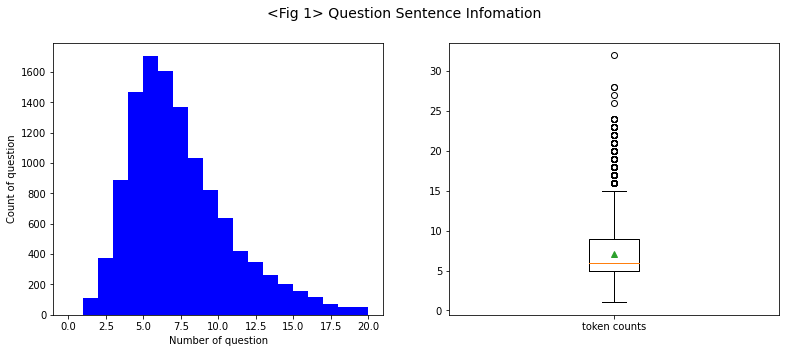

=========================================< Sentence Info >==========================================
길이 최대:      32
길이 최소:       1
길이 평균:      7.035
길이 표준편차:   3.524

 25/100분위:    5.000
 50/100분위:    6.000
 75/100분위:    9.000
 MAX/100분위:  15.000
 IQR:   4.000


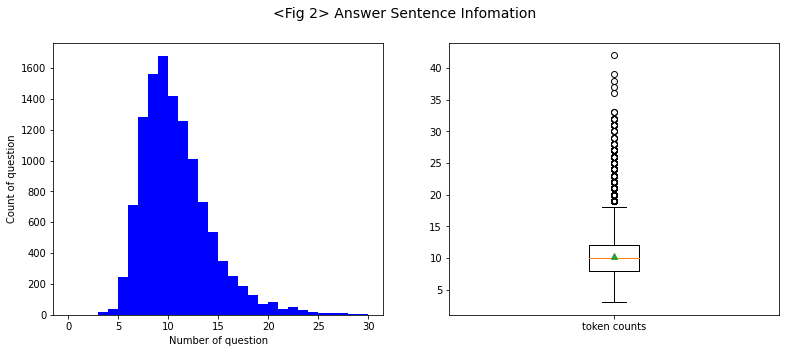

=========================================< Sentence Info >==========================================
길이 최대:      42
길이 최소:       3
길이 평균:     10.377
길이 표준편차:   3.575

 25/100분위:    8.000
 50/100분위:   10.000
 75/100분위:   12.000
 MAX/100분위:  18.000
 IQR:   4.000


In [11]:
def get_sentence_len(tensor):
    counts = []
    for sentence in tensor.tolist():
        try:
            idx = sentence.index(0)
            counts.append(idx)
        except:
            counts.append(len(sentence))
    return counts


enc_counts = get_sentence_len(enc_tensor)
dec_counts = get_sentence_len(dec_tensor)

show_sentence_length(enc_counts, "<Fig 1> Question Sentence Infomation", [0, 20])
show_sentence_length(dec_counts, "<Fig 2> Answer Sentence Infomation", [0, 30])

<br>

#### 토큰별 사용 빈도 확인
***
+ 추후 단어사전 크기를 설정하기 위해, 토큰별 사용 빈도를 확인 합니다.


+ 평균 약 30회 사용 되었고 4분위의 토큰은 약 16회 사용 되었습니다.
***

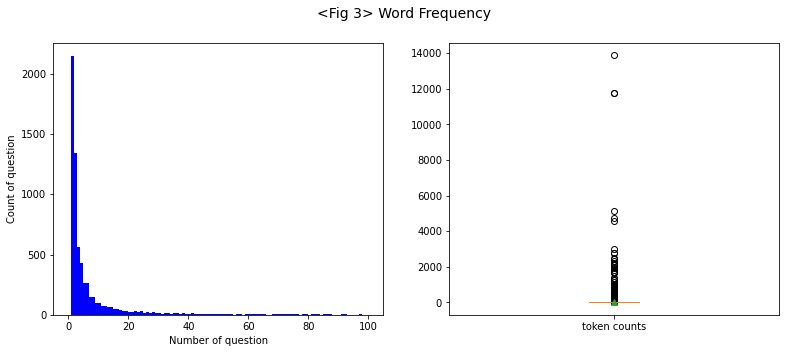

=========================================< Sentence Info >==========================================
길이 최대:    13870
길이 최소:       1
길이 평균:     30.048
길이 표준편차: 310.114

 25/100분위:    1.000
 50/100분위:    2.000
 75/100분위:    7.000
 MAX/100분위:  16.000
 IQR:   6.000


In [12]:
freq = [value for value in tokenizer.word_counts.values()]

show_sentence_length(freq, "<Fig 3> Word Frequency", [0, 100])

<br>

#### 사용 빈도 4분위에 해당하는 토큰 개수 확인
***
+ 사용 빈도 4분위에 해당하는 토큰의 수는 총 5,872개 입니다.
***

In [13]:
def wordNumByFreq(tokenizer, freq_num):
    sorted_freq = sorted(tokenizer.word_counts.items(), key=lambda x: x[1])
    for idx, (_, freq) in enumerate(sorted_freq):
        if freq > freq_num: break;
    return idx


print(f"Words Used Under {16}: {wordNumByFreq(tokenizer, 16):,}")

Words Used Under 16: 5,872


<br>

#### 최종 토크나이저 생성
***
+ 사용 빈도 4분위에 해당하는 토큰의 수는 총 5,872개 입니다.


+ 또한, 질문(Question) 문장의 길이가 15 이하이고 대답(Answer) 문장의 길이가 18 이하인 문장만 추출 합니다.


+ 문장 정수 인코딩은 데이터 증강 후 수행 합니다.
***

In [14]:
#토크나이저 생성===============
concat = pd.concat([dataset["Q"], dataset["A"]])
tokenizer = get_tokenizer(concat, 5872)
#End===========================


#문장 길이 정제================
q = dataset["Q"].apply(lambda x: len(tokenizer.texts_to_sequences([x])[0]) <= 15)
a = dataset["A"].apply(lambda x: len(tokenizer.texts_to_sequences([x])[0]) <= 18)
dataset = dataset[q & a]
#End===========================


print("Tokenizer Vocab Size:", f"{len(tokenizer.word_index):,}")

Tokenizer Vocab Size: 5,872


<br>

#### 테스트 데이터 분할
***
+ 모델 검증 단계에서 사용할 100개의 테스트 데이터를 분할 합니다.
***

In [15]:
test_dataset = dataset[:100]
dataset = dataset[100:]

display(test_dataset.sample(5))

,Q,A
74,같이 놀 러 갈 친구 가 없 어,<sos> 혼자 도 좋 아요 . <eos>
87,개념 도 놓 고 옴,<sos> 그게 제일 중요 한 건데요 . <eos>
68,강아지 키우 고 싶 어,<sos> 책임 질 수 있 을 때 키워 보 세요 . <eos>
79,같이 할 수 있 는 취미 생활 뭐 있 을까,<sos> 함께 하 면 서로 를 더 많이 알 게 될 거 예요 . <eos>
88,개념 이 없 어,<sos> 그게 제일 중요 한 건데요 . <eos>


<br>

## 5. 데이터 증강
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 데이터 전처리를 통해 총 11,750개의 데이터를 확보하였습니다. 이는 학습하기 부족한 수로, 데이터 증강을 통해 데이터를 늘립니다. 데이터 증강 방법은 데이터 문장으로부터 무작위로 단어를 선택 합니다. 이미 학습된 Word2Vec을 이용하여 선택한 단어와 비슷한 단어를 추출 합니다. 즉, 임베딩 간 거리가 가까운 단어를 추출하는 것입니다. 선택한 단어를, 추출한 비슷한 단어로 대체 합니다. 해당 문장을 학습 데이터로 사용 합니다. 이러한 방법을 사용하여 질문 데이터와 대답 데이터를 각각 증강 합니다. 최종 29,951개의 학습 데이터를 확보 합니다.
</span>

***

#### 한국어 Word2Vec 불러오기
***
+ 한국어로 사전 훈련된 Embedding 모델을 불러옵니다.
***

In [16]:
w2v = gensim.models.Word2Vec.load('./dataset/ko.bin')

#### 학습 데이터 출처
***
+ Kyubyong Park, Pre-trained word vectors of 30+ languages(2016), https://github.com/Kyubyong/wordvectors
***

#### _'bin' File Load Error_
***
+ gensim의 버전으로 인하여 `ko.bin` 파일을 읽을 수 없는 이슈가 존재합니다. 이러한 경우 아래의 코드를 통해 버전을 낮추어 재설치 합니다.

> `$ pip install --upgrade gensim==3.8.3`
***

<br>

#### 데이터 증강 함수 생성
***
+ `lexical_sub` 함수는 문장을 입력하면 무작위로 선택한 단어를 wrod2vec에 기반하여 비슷한 단어로 대체하여 문장을 반환 합니다.


+ `argument_data` 함수는 `Question`과 `Answer` 데이터에 맞추어 데이터 증강을 실시 합니다.
***

In [17]:
#Lexical Substitution=================================
def lexical_sub(sentence, word2vec, enc_arg=True):
    toks = sentence.split()
    if not enc_arg:   #<sos>, <eos> 토큰 제외
        toks = toks[1:-1]

    _from = random.choice(toks)
    
    try:
        _to = word2vec.most_similar(_from)[0][0]
    except:
        return "_"
    
    res = ""
    for tok in sentence.split():
        if tok == _from:
            res += _to + " "
        else:
            res += tok + " "
    return res
#End==================================================


#Question, Answer에 따른 데이터 증강 함수=============
def argument_data(dataset, word2vec, enc_arg=True):
    qna = "Q" if enc_arg else "A"
    arg = dataset[qna].apply(lambda x: lexical_sub(x, word2vec, enc_arg))
    
    arg_data = dataset.copy()
    arg_data[qna] = arg
    
    arg_data = arg_data[arg_data[qna] != "_"]
    return arg_data
#End==================================================

<br>

#### 데이터 증강 수행
***
+ 앞서 정의한 함수를 사용하여 `Quenstion`과 `Answer` 데이터별로 데이터 증강을 수행 합니다.


+ `걱정 좀 없이 살고 싶다.` 문장을 바탕으로 `걱정 조금 없이 살고 싶다.`의 문장을 생성 한 것을 확인할 수 있습니다.
***

In [18]:
#데이터 증강==========================================
enc_alpha = argument_data(dataset, w2v, True)
dec_alpha = argument_data(dataset, w2v, False)
#End==================================================


#데이터 증강 출력=====================================
enc_idx = set(dataset.index)
enc_alpha_idx = set(enc_alpha.index)
dec_alpha_idx = set(dec_alpha.index)

vet = enc_idx & enc_alpha_idx & dec_alpha_idx
vet = list(vet)[0]

print(f"Question Sentence: {dataset['Q'][vet]} ======> {enc_alpha['Q'][vet]}")
print(f"Answer Sentence: {dataset['A'][vet]} ======> {dec_alpha['A'][vet]}")
#End==================================================

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # Remove the CWD from sys.path while we load stuff.


Question Sentence: 걱정 좀 없이 살 고 싶 다 . ======> 걱정 조금 없이 살 고 싶 다 . 
Answer Sentence: <sos> 누구 나 걱정 은 있 어요 . <eos> ======> <sos> 누구 나 걱정 은 있 는데요 . <eos> 


<br>

#### 기존 데이터와 증강 데이터 합치기
***
+ 기존 11,750개의 데이터로부터 데이터 증강을 수행하여 최종 29,951개의 데이터를 획득 합니다.


+ 또한 모델의 올바른 학습을 위하여 데이터를 무작위로 섞어 줍니다.
***

In [19]:
dataset = pd.concat([dataset, enc_alpha, dec_alpha])
dataset = dataset.sample(frac=1)

print(f"Dataset Num: {len(dataset):,}")
display(dataset[:5])

Dataset Num: 29,951


,Q,A
9539,내일 대관식 이 야,<sos> 떨리 겠 어요 . <eos>
882,내 사랑 은 어디 있 나,<sos> 같 은 하늘 아래 묻히 에 . <eos>
2311,산 뛰어넘 어 산 이 네,<sos> 그래도 넘 을 수 있 을 거 예요 . <eos>
7158,오늘 도 보 고 왔 어서,<sos> 그것 이 최선 의 선택 일거 라 생각 해요 . <eos>
107,건강 관리,<sos> 운동 을 해의 보 세요 . <eos>


<br>

#### 문장 정수 인코딩 수행
***
+ 최종적으로 문장의 정수 인코딩을 수행하여 줍니다.


+ 증강 데이터를 합하여 최종 29,951개의 학습 데이터를 얻습니다.
***

In [20]:
enc_tensor = encoding_sentence(dataset["Q"], tokenizer)
dec_tensor = encoding_sentence(dataset["A"], tokenizer)

print("Data num:", f"{len(enc_tensor):,}")

Data num: 29,951


<br>

## 6. Transformer 모델 생성
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 트랜스포머 모델은 크게 인코더 부분과 디코더 부분으로 이루어져 있습니다. 모델의 목표는 'seq2seq'의 '시계열 데이터를 입력하여 시계열 데이터를 얻는 것'과 동일합니다. 기본적인 아이디어는 'Attention'만을 이용하여 'seq2seq'를 수행 하는 것입니다. 또한, 기존의 'Attention'은 RNN을 이용하여 데이터의 입력이 '순차적'으로 수행되었지만, 트랜스포머의 데이터 입력은 '동시에' 혹은 '병렬적'으로 수행된다는 특징이 있습니다. Transformer의 작동 방식과 각 레이어의 역할에 대한 설명은 'aiffel_exploration' 저장소((Repository)의 <a href="https://nbviewer.org/github/YAGI0423/aiffel_exploration/blob/master/exploration_15/EX15_v3_1.ipynb">[Exploration 15]</a>에서 자세히 다루고 있습니다. 인코더와 디코더 레이어는 2층을 쌓았으며, 학습 데이터 수가 적기 때문에 벡터 사이즈와 피드포워드 레이어의 유닛 수를 128로 설정 하였습니다.
</span>

***

#### Positional 인코딩 레이어 및 멀티 헤드 어텐션 레이어 함수 정의
***
+ Positional 인코딩 레이어 및 멀티 헤드 어텐션 레이어 함수를 정의 합니다.
***

In [21]:
#Positional Encoding==================================================
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table
#End==================================================================


#MultiHeadAttention====================================================
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights
#End==================================================================

    
#Position-wise Feed-Forward Network===================================
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out
#End==================================================================


#Mask 레이어==========================================================
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

#End==================================================================

<br>

#### 인코더 레이어 및 디코더 레이어 함수 정의
***
+ 인코더 레이어 및 디코더 레이어 함수를 정의 생성합니다.
***

In [22]:
#Encoder 레이어=======================================================
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn
#End==================================================================


#Decoder 레이어=======================================================
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
       
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn
#End==================================================================

<br>

#### 인코더 및 디코더 함수 정의
***
+ 인코더 및 디코더 함수를 정의 생성합니다.
***

In [23]:
#Encoder==============================================================
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns
#End==================================================================


#Decoder==============================================================
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns
#End==================================================================

<br>

#### 트랜스포머 함수 정의
***
+ 트랜스포머 생성 함수를 정의합니다.
***

In [24]:
class Transformer(tf.keras.Model):
    def __init__(
        self,
        n_layers, d_model, n_heads, d_ff,
        src_vocab_size, tgt_vocab_size,
        pos_len,
        dropout=0.2,
        shared=True
    ):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

            
    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

<br>

#### 모델 생성
***
+ 인코더와 디코더는 동일한 토크나이저를 공유하고 있으므로 모두 5,872개로 설정 합니다.
***

In [25]:
transformer = Transformer(
    n_layers=2,
    d_model=128,
    n_heads=8,
    d_ff=128,
    dropout=0.5,
    pos_len=200,
    shared=True,
    src_vocab_size=5872, tgt_vocab_size=5872
)

<br>

## 7. 모델 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 학습 옵티마이저는 Adam을 사용하며 배치 사이즈는 64로 설정하고 총 10회 학습 합니다. 최종 손실값은 0.740 입니다. 「지루하다, 놀러가고 싶어.」, 「오늘 일찍 일어났더니 피곤하다.」 등의 총 4개의 문장을 입력한 결과, 「시간이 필요한가 봐요.」, 「아침 일이 많았나 봅니다.」 등의 문장을 출력하였습니다. [표 1]은 입력 문장과 그에 대한 모델의 출력 문장을 제시한 것입니다.
</span><br><br>

|Index|Question|Answer|
|:--------:|:--------:|:--------:|
|1|지루하다, 놀러가고 싶어.|시간이 필요한가봐요.|
|2|오늘 일찍 일어났더니 피곤하다.|아침 일이 많았나 봅니다 .|
|3|간만에 여자친구랑 데이트 하기로 했어.|좋은 친구가 여기가 여기 가길 바랄게요.|
|4|집에 있는다는 소리야.|익숙 &lt;UNK>을 &lt;UNK> 군요.|

[표 1] Transformer 모델의 생성 문장

***

#### 학습 옵티마이저 설정
***
+ 학습률의 경우 고정된 값을 이용하지 않고 LearningRateScheduler를 이용하여, 높은 학습률로부터 점차 낮추는 방식을 사용 합니다.


+ 옵티마이저는 Adam을 이용합니다.
***

In [26]:
#LearningRateScheduler=====================
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)
#End=======================================


#손실 함수=================================  
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)    
#End=======================================

    
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

<br>

#### 학습 함수 정의
***
+ 'GradientTape'를 이용하여 학습 함수를 정의 합니다.
***

In [27]:
# Train Step 함수======================================
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns
#End===================================================

<br>

#### 모델 학습
***
+ 앞서 생성한 모델을 학습 합니다.


+ 배치 사이즈는 64, 학습 회수는 10회로 설정 합니다.
***

In [28]:
def model_fit(enc_train, dec_train, model, epochs, batch_size):
    for epoch in range(epochs):
        total_loss = 0

        idx_list = list(range(0, enc_train.shape[0], batch_size))
        random.shuffle(idx_list)
        t = tqdm(idx_list)

        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            train_step(
                enc_train[idx:idx+batch_size],
                dec_train[idx:idx+batch_size],
                model,
                optimizer
            )

            total_loss += batch_loss

            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
            

model_fit(enc_tensor, dec_tensor, transformer, epochs=10, batch_size=64)

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

<br>

#### 예문 생성
***
+ `지루하다, 놀러가고 싶어.`, `오늘 일찍 일어났더니 피곤하다.` 등의 총 4개의 문장을 모델에 입력하여 생성 문장을 확인 합니다.


+ 그 결과, `시간이 필요한가봐요.`, `아침 일이 많았나 봅니다.` 등의 예문을 출력하였습니다.
***

In [29]:
def translate(sentence, model, tokenizer, enc_tensor, dec_tensor):
    enc_maxlen = enc_tensor.shape[-1]
    dec_maxlen = dec_tensor.shape[-1]

    sos_idx = tokenizer.word_index['<sos>']
    eos_idx = tokenizer.word_index['<eos>']

    sentence = preprocess_sentence(sentence)

    m = Mecab()
    sentence = m.morphs(sentence)

    _input = tokenizer.texts_to_sequences([sentence])
    _input = tf.keras.preprocessing.sequence.pad_sequences(
        _input,
        maxlen=enc_maxlen,
        padding='post'
    )

    ids = []
    output = tf.expand_dims([sos_idx], 0)

    for i in range(dec_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(
            _input, output
        )

        predictions, enc_attns, dec_attns, dec_enc_attns = model(
            _input, output, enc_padding_mask, combined_mask, dec_padding_mask
        )

        predicted_id = tf.argmax(
            tf.math.softmax(predictions, axis=-1)[0, -1]
        ).numpy().item()

        if predicted_id == eos_idx:
            result = tokenizer.sequences_to_texts([ids])
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = tokenizer.sequences_to_texts([ids])
    return result


print("=" * 100)
test_sentences = [
    "지루하다, 놀러가고 싶어.",
    "오늘 일찍 일어났더니 피곤하다.",
    "간만에 여자친구랑 데이트 하기로 했어.",
    "집에 있는다는 소리야."
]

for sentence in test_sentences:
    ans = translate(sentence, transformer, tokenizer, enc_tensor, dec_tensor)[0]
    print(f"Quenstion: {sentence:<30}\tAnswer: {ans:<30}")
print("=" * 100)

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 시간 이 필요 한가 봐요 .               
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 아침 일 이 많 았 나 봅니다 .            
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 좋 은 친구 가 여기 가 여기 가 길 바랄게요 .   
Quenstion: 집에 있는다는 소리야.                  	Answer: 익숙 <UNK> 을 <UNK> 군요 .         


<br>

## 8. 모델 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; BLEU를 이용하여 100개의 테스트 데이터를 평가 합니다. BLEU는 0에서 1사이의 값을 가지며, 값이 높을 수록 좋은 문장에 해당 합니다. [표 2]는 BLEU 점수 척도를 제시한 것 입니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 예제에서는 Beam search를 이용하여 좀 더 정확한 평가를 도모 합니다. 테스트 데이터 100개에 대한 BLEU는 0.419로, [표 2]를 바탕으로 해석하였을 때, 이는 모델의 대답(Answer)이 양호한 수준이라 할 수 있습니다. 
</span><br><br>

|BLEU score|Answer|
|:--------:|:--------:|
|10점 미만|거의 의미 없음|
|10 ~ 19점|핵심을 파악하기 어려움|
|20 ~ 29점|요점은 명확하지만 많은 문법적 오류가 있음|
|30 ~ 39점|이해할 수 있는 양호한 번역|
|40 ~ 49점|고품질 번역|
|50 ~ 60점|매우 우수한 품질의 적절하고 유창한 번역|
|60점 초과|대체적으로 사람보다 우수한 품질|

[표 2] BLEU 점수 척도(https://cloud.google.com/translate/automl/docs/evaluate?hl=ko#bleu)

***

#### Beam Search 및 BLEU 계산 함수 정의
***
+ Beam Search 문장 획득 함수와 BLEU를 구하기 위한 함수를 정의 합니다.
***

In [30]:
#모델 입력 및 출력 함수======================
def calc_prob(src_ids, tgt_ids, model):
    enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(
        src_ids, tgt_ids
    )
    
    predictions, enc_attns, dec_attns, dec_enc_attns = model(
        src_ids, tgt_ids, enc_padding_mask, combined_mask, dec_padding_mask
    )
    return tf.math.softmax(predictions, axis=-1)
#End=========================================


#Beam search=================================
def beam_search_decoder(
    sentence, model, tokenizer,
    enc_maxlen, dec_maxlen,
    beam_size
):
    sos_idx = tokenizer.word_index['<sos>']
    eos_idx = tokenizer.word_index['<eos>']

    tokens = tokenizer.texts_to_sequences([sentence])
    src_in = tf.keras.preprocessing.sequence.pad_sequences(
        tokens,
        maxlen=enc_maxlen,
        padding='post'
    )

    pred_cache = np.zeros((beam_size * beam_size, dec_maxlen), dtype=np.long)
    pred = np.zeros((beam_size, dec_maxlen), dtype=np.long)

    eos_flag = np.zeros((beam_size, ), dtype=np.long)
    scores = np.ones((beam_size, ))

    pred[:, 0] = sos_idx

    dec_in = tf.expand_dims(pred[0, :1], 0)
    prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()
    
    
    for seq_pos in range(1, dec_maxlen):
        score_cache = np.ones((beam_size * beam_size, ))

        # init
        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            score_cache[cache_pos:cache_pos+beam_size] = scores[branch_idx]
            pred_cache[cache_pos:cache_pos+beam_size, :seq_pos] = \
            pred[branch_idx, :seq_pos]

        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            if seq_pos != 1:   # 모든 Branch를 로 시작하는 경우를 방지
                dec_in = pred_cache[branch_idx, :seq_pos]
                dec_in = tf.expand_dims(dec_in, 0)

                prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

            for beam_idx in range(beam_size):
                max_idx = np.argmax(prob)

                score_cache[cache_pos+beam_idx] *= prob[max_idx]
                pred_cache[cache_pos+beam_idx, seq_pos] = max_idx

                prob[max_idx] = -1

        for beam_idx in range(beam_size):
            if eos_flag[beam_idx] == -1: continue

            max_idx = np.argmax(score_cache)
            prediction = pred_cache[max_idx, :seq_pos+1]

            pred[beam_idx, :seq_pos+1] = prediction
            scores[beam_idx] = score_cache[max_idx]
            score_cache[max_idx] = -1

            if prediction[-1] == eos_idx:
                eos_flag[beam_idx] = -1
    return pred
#End=========================================


#bleu 계산 함수==============================
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu(
        [reference],
        candidate,
        weights=weights,
        smoothing_function=SmoothingFunction().method1
    )
#End=========================================


#beam ssearch 및 bleu 계산 함수==============
def beam_bleu(reference, ids, tokenizer, verbose=False):
    reference = reference.split()

    total_score = 0.0
    for _id in ids:
        seq2text = tokenizer.sequences_to_texts([_id])[0]
        _idx =  seq2text.find("<eos>")
        seq2text = seq2text[6:_idx]
        candidate = seq2text.split()
        score = calculate_bleu(reference, candidate)
        
        if verbose:
            print("=" * 100)
            print("Reference:".ljust(10), " ".join(reference))
            print("Candidate:".ljust(10), " ".join(candidate), end="\n\n")
            print("BLEU:".ljust(10), f"{calculate_bleu(reference, candidate):.3f}")
            print("=" * 100, end="\n\n")
        
        total_score += score
        
    return total_score / len(ids)
#End=========================================

<br>

#### 예문의 Beam search 문장과 BLEU 출력하기
***
+ Reference에 해당하는 `땀을 식혀 주세요.` 문장과 모델이 출력한 5개의 Candidate 문장과 BLEU를 출력 합니다.
***

In [36]:
idx = 15
test_enc_sentence = test_dataset["Q"][idx]

test_dec_tensor = encoding_sentence(test_dataset["A"], tokenizer)
test_dec_sentence = tokenizer.sequences_to_texts([test_dec_tensor[idx]])[0]
_idx = test_dec_sentence.find("<eos>")
test_dec_sentence = test_dec_sentence[6:_idx]


ids = beam_search_decoder(
    test_enc_sentence,
    transformer, tokenizer,
    enc_tensor.shape[-1], dec_tensor.shape[-1],
    beam_size=5
)

bleu = beam_bleu(test_dec_sentence, ids, tokenizer, verbose=True)

Reference: 땀 을 식혀 주 세요 .
Candidate: 잘 하 셨 어요 .

BLEU:      0.044

Reference: 땀 을 식혀 주 세요 .
Candidate: 잘 하 셨 어요 는데

BLEU:      0.000

Reference: 땀 을 식혀 주 세요 .
Candidate: 잘 하 셨 나 .

BLEU:      0.044

Reference: 땀 을 식혀 주 세요 .
Candidate: 잘 <UNK> 셨 어요 .

BLEU:      0.044

Reference: 땀 을 식혀 주 세요 .
Candidate: 잘 하 셨 나 는데

BLEU:      0.000



<br>

#### 테스트 데이터 BLEU 구하기
***
+ 앞서 정의한 함수를 이용하여 100개의 테스트 데이터의 BLEU를 구합니다.


+ 최종 BLEU는 0.419로 매우 준수한 성능에 해당합니다.
***

In [34]:
enc_maxlen = enc_tensor.shape[-1]
dec_maxlen = dec_tensor.shape[-1]

aver_bleu = 0
for _, que, ans in test_dataset.itertuples():
    ids = beam_search_decoder(
        que,
        transformer, tokenizer,
        enc_maxlen, dec_maxlen,
        beam_size=5
    )
    
    test_dec_sentence = tokenizer.sequences_to_texts([que])[0]
    _idx = test_dec_sentence.find("<eos>")
    test_dec_sentence = test_dec_sentence[6:_idx]
    
    aver_bleu += beam_bleu(test_dec_sentence, ids, tokenizer, verbose=False)
    
print("=" * 100)
print(f"Test Data BLEU: {aver_bleu:.3f}")
print("=" * 100)

Test Data BLEU: 0.419


<br>

## 6. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Transformer 모델을 이용하여 한국어 챗봇 모델을 생성하고 이를 BLEU를 기준으로 삼아 평가하였습니다. 특히 정확한 평가를 위해 Beam search를 사용하여 Cadidate 문을 5개 생성하고 이를 BLEU로 평가하였습니다. 테스트 데이터는 학습 데이터 11,750개로부터 100개를 분할 한 것입니다. 이후 나머지 11,650개의 데이터를 이용하여 데이터 증강을 실시하여 최종 29,951개의 데이터를 학습 데이터로 이용하였습니다. 
</span><br><br>  

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 테스트 데이터에 대한 모델의 BLEU score는 0.419입니다. 0.4의 경우 '이해할 수 있는 양호한 문장'에 해당하므로 모델의 성능이 준수하다고 평가할 수 있습니다. [표 3]은 Transformer 모델의 생성 문장을 제시한 것입니다.
</span><br><br>

|Index|Question|Answer|
|:--------:|:--------:|:--------:|
|1|지루하다, 놀러가고 싶어.|시간이 필요한가봐요.|
|2|오늘 일찍 일어났더니 피곤하다.|아침 일이 많았나 봅니다 .|
|3|간만에 여자친구랑 데이트 하기로 했어.|좋은 친구가 여기가 여기 가길 바랄게요.|
|4|집에 있는다는 소리야.|익숙 &lt;UNK>을 &lt;UNK> 군요.|

[표 3] Transformer 모델의 생성 문장

***

#### 형상관리 기록
***
+ v1_1: 실습 예제 진행


+ v1_2: 제출 예제 진행 ~ (데이터 증강)


+ v1_3: 제출 예제 진행 ~ (모델 학습 및 예문 생성)


+ v2_1: 본문 내용 작성 및 제출 예제 완료 ~ (BLEU 평가)
***